In [16]:
import numpy as np
import pandas as pd
from scipy.stats import skewnorm, skew
import matplotlib.pyplot as plt
from sympy import Symbol
from sympy.solvers import solve

In [17]:
np.random.seed(42)

In [130]:
def delta_fn(alpha):
    delta = alpha/(1+alpha**2)**(0.5)
    return(delta)

def skewness_fn(alpha):
    delta = delta_fn(alpha)
    first_term = (4.-np.pi)/2.
    num = (delta * (2./np.pi)**0.5)**3.
    denom = (1-(2.*delta**2/np.pi))**(1.5)
    second_term = num/denom
    return first_term * second_term

def variance_fn(alpha, omega=1):
    delta = delta_fn(alpha)
    return omega**2 * (1-(2*delta**2)/np.pi)
    
def mean_fn(alpha, omega=1, xi=0):
    delta = delta_fn(alpha)
    return xi + omega * delta * np.sqrt(2/np.pi)

def alpha_solver(skewness=0):
  if skewness==0:
    return 0
  elif abs(skewness) > 1:
    raise ValueError('No Real Solutions when abs(skewness) > 1!')
  else: 
    alpha = Symbol('alpha')
    return float(solve(skewness_fn(alpha)-skewness, alpha)[0])

def omega_solver(alpha, variance=1):
    delta = delta_fn(alpha)
    return float((variance / (1.-(2.*delta**2)/np.pi))**(1/2.))

def xi_solver(alpha, omega, mean=0):
    delta = delta_fn(alpha)
    return float(mean - omega*delta*np.sqrt(2/np.pi))

class SkewNorm:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        self.get_stats()
        self.gen_sim()
    def get_stats(self):
        self.stats = skewnorm.stats(self.alpha, loc=self.xi, scale=self.omega, moments='mvsk')
    def gen_sim(self, size=None):
        if size:
            self.sim_size = size
        else:
            size = self.sim_size
        self.sim = sorted(skewnorm.rvs(self.alpha, loc=self.xi, scale=self.omega, size=size))
        
def skewnorm_solver(skewness=0, variance=1, mean=0):
    alpha = alpha_solver(skewness)
    alpha_check = skewness_fn(alpha)
    assert abs(alpha_check - skewness) < 1e-6

    omega = omega_solver(alpha,variance)
    omega_check = variance_fn(alpha, omega)
    assert abs(omega_check - variance) < 1e-6

    xi = xi_solver(alpha, omega, mean)
    xi_check = mean_fn(alpha, omega, xi)
    assert abs(xi_check - mean) < 1e-6
    res = SkewNorm(alpha=alpha, omega=omega, xi=xi, sim_size=10000, hist_bins=100)
    assert abs(res.stats[0] - mean) < 1e-6
    assert abs(res.stats[1] - variance) < 1e-6
    assert abs(res.stats[2] - skewness) < 1e-6
    return res

A distribution from the **skewnormal** family is uniquely specified by a combination of $\alpha$, the **shape** parameter, $\omega$, the **scale** parameter and $\xi$, the **location** parameter.

The following equations are written in terms of $\delta$, which is a univariate function of $\alpha$, the shape parameter of the skewnormal distribution.

$ \delta = \frac{\alpha}{\sqrt{1+\alpha^2}} $

First we must solve for the shape parameter by solving for delta in the following equation that defines the skewness $(\gamma_1)$ in terms of $\delta$.

$ \gamma_1 (X) = \frac{4-\pi}{2} \frac{(\delta\sqrt{(2/\pi})^3}{(1-2\delta^2/\pi)^\frac{3}{2}} $

Then, given the fixed $\delta$ we have solved for in the previous section, we can solve for $\omega$ as a univariate function of $Var(X)$.

$ Var(X) = \omega^2 (1-\frac{2\delta^2}{\pi}) $

Finally, given $\alpha$ (and thereby $\delta$) and $\omega$ we can solve for $\xi$ to fit our desired mean.

$ E(X) = \xi + \omega\delta \sqrt{\frac{2}{\pi}} $

In [131]:
variations = {
    'basecase': {'skewness':0, 'variance': np.log(1.10)**2, 'mean': np.log(100)},
    'high_variance': {'skewness':0, 'variance': np.log(1.15)**2, 'mean': np.log(100)},
    'low_variance': {'skewness':0, 'variance': np.log(1.05)**2, 'mean': np.log(100)},
    'right_skew': {'skewness':0.5, 'variance': np.log(1.10)**2, 'mean': np.log(100)},
    'left_skew': {'skewness':-0.5, 'variance': np.log(1.10)**2, 'mean': np.log(100)},
    'right_skew_hiv': {'skewness':0.5, 'variance': np.log(1.15)**2, 'mean': np.log(100)},
    'right_skew_lov': {'skewness':0.5, 'variance': np.log(1.05)**2, 'mean': np.log(100)},
    'left_skew_hiv': {'skewness':-0.5, 'variance': np.log(1.15)**2, 'mean': np.log(100)},
    'left_skew_lov': {'skewness':-0.5, 'variance': np.log(1.05)**2, 'mean': np.log(100)}
}

distributions = {k: skewnorm_solver(**v).sim for k,v in variations.items()}
log_df = pd.DataFrame(distributions)
df = np.exp(log_df)

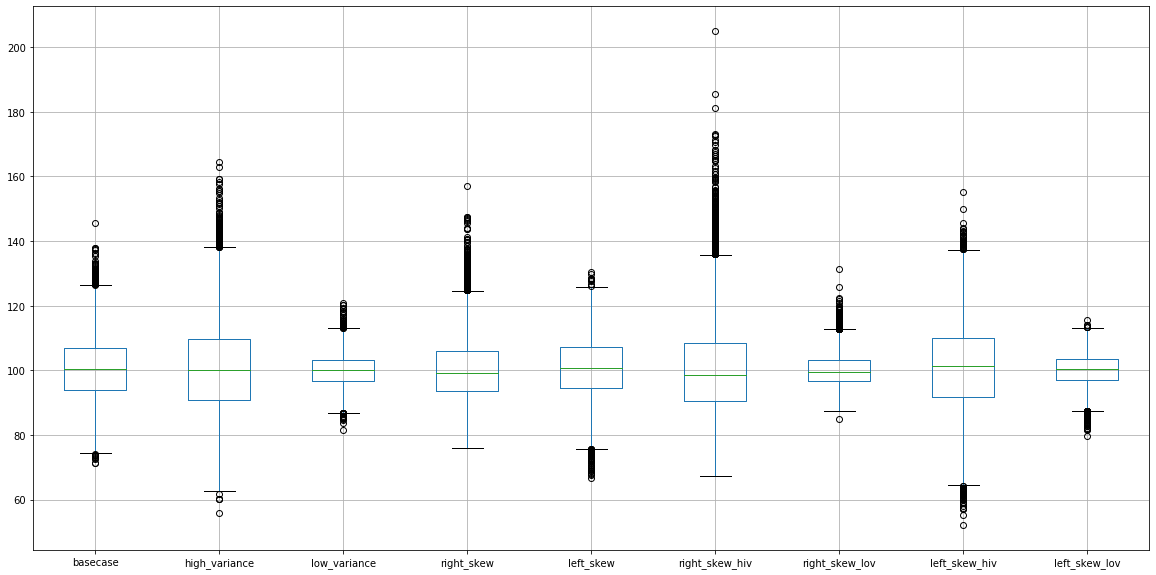

In [132]:
df.boxplot(figsize=(20,10))

In [133]:
print(df.quantile(0.05, interpolation='lower'))

df.loc[:499].mean()

basecase          85.593270
high_variance     79.406832
low_variance      92.145142
right_skew        86.795617
left_skew         84.330351
right_skew_hiv    81.102960
right_skew_lov    92.951335
left_skew_hiv     77.534339
left_skew_lov     91.619526
Name: 0.05, dtype: float64


basecase          82.481579
high_variance     74.744343
low_variance      90.303623
right_skew        84.336086
left_skew         80.170523
right_skew_hiv    77.993028
right_skew_lov    91.629110
left_skew_hiv     71.667647
left_skew_lov     89.087705
dtype: float64

In [134]:
print(df.quantile(0.95, interpolation='lower'))
df.loc[9499:].mean()

basecase          117.339050
high_variance     125.595943
low_variance      108.281579
right_skew        118.849622
left_skew         115.191024
right_skew_hiv    128.521751
right_skew_lov    109.166277
left_skew_hiv     123.139818
left_skew_lov     107.493851
Name: 0.95, dtype: float64


basecase          121.985764
high_variance     133.421181
low_variance      110.510872
right_skew        125.243174
left_skew         118.384073
right_skew_hiv    139.223283
right_skew_lov    111.923604
left_skew_hiv     128.590242
left_skew_lov     109.030335
dtype: float64

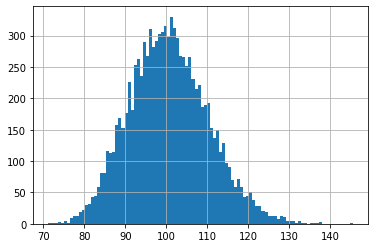

In [135]:
df['basecase'].hist(bins=100)

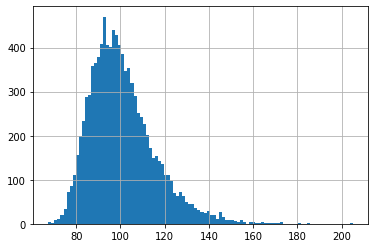

In [136]:
df['right_skew_hiv'].hist(bins=100)

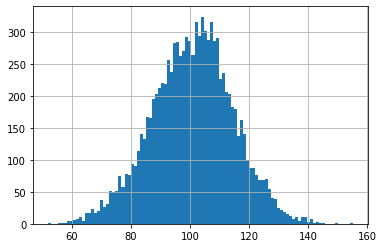

In [137]:
df['left_skew_hiv'].hist(bins=100)